In [17]:
!pip install comet-ml==3.31.17

  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.8
    Uninstalling urllib3-1.26.8:
      Successfully uninstalled urllib3-1.26.8
  Attempting uninstall: comet-ml
    Found existing installation: comet-ml 3.1.4
    Uninstalling comet-ml-3.1.4:
      Successfully uninstalled comet-ml-3.1.4


In [50]:
from comet_ml import Experiment
import configparser


In [51]:
config = configparser.ConfigParser()
config.read('./configfile.ini')
type_env = "comet_ml_prod" #comet_ml_prod
COMET_API_KEY = config[type_env]['api_key']
COMET_PROJECT_NAME = config[type_env]['project_name_xgboost']
COMET_WORKSPACE = config[type_env]['workspace']

comet_exp_obj = Experiment(api_key=COMET_API_KEY,
                           project_name=COMET_PROJECT_NAME,
                           workspace=COMET_WORKSPACE,
                           log_code=True
                          )
comet_exp_obj.set_name(name="XGBOOST MODELS")
#comet_exp_obj.log_notebook("Advanced models.ipynb")

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/yasmine/xgboost-baseline/5efbfe58cf0746b8b3de8c07b9c36eca
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     validation_0_auc [705] : (0.570037, 0.737071)
COMET INFO:     validation_1_auc [644] : (0.56933, 0.693314)
COMET INFO:   Others:
COMET INFO:     Name : XGBOOST MODELS
COMET INFO:   Parameters:
COMET INFO:     add_indicator    : False
COMET INFO:     begin_iteration  : 0
COMET INFO:     colsample_bytree : 0.5
COMET INFO:     copy             : True
COMET INFO:     end_iteration    : 567
COMET INFO:     eval_metric      : auc
COMET INFO:     feature_names    : ['Distance_from_net', 'Angle_from_net']
COMET INFO:     feature_types    : ['float', 'float']
COMET INFO:     fill_value       : 1
COMET INFO:     learning_rate    : 0.1
COMET I

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibrationDisplay
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import pickle


In [4]:
xgb.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [5]:
import pandas as pd
train_data= pd.read_csv("./train_set.csv")
train_data

gameID eventType  period periodTime periodType  \
0       2015020001      Shot       1      00:51    REGULAR   
1       2015020001      Shot       1      01:05    REGULAR   
2       2015020001      Shot       1      01:06    REGULAR   
3       2015020001      Shot       1      01:53    REGULAR   
4       2015020001      Shot       1      02:37    REGULAR   
...            ...       ...     ...        ...        ...   
310926  2018021270      Shot       3      15:15    REGULAR   
310927  2018021270      Shot       3      15:23    REGULAR   
310928  2018021270      Goal       3      19:05    REGULAR   
310929  2018021270      Shot       3      19:18    REGULAR   
310930  2018021270      Shot       3      19:25    REGULAR   

               teamOfShooter homeOrAway  xCoord  yCoord         shooter  ...  \
0        Toronto Maple Leafs       home   -55.0     6.0      Brad Boyes  ...   
1        Toronto Maple Leafs       home   -79.0     0.0     Nazem Kadri  ...   
2        Toronto Maple Leafs       home   -75.0    -1.0     Nazem Kadri  ...   
3        Toronto Maple Leafs       home   -55.0   -36.0   Daniel Winnik  ...   
4        Toronto Maple Leafs       home   -61.0    -1.0   Joffrey Lupul  ...   
...                      ...        ...     ...     ...             ...  ...   
310926     Los Angeles Kings       home   -64.0     5.0   Tyler Toffoli  ...   
310927  Vegas Golden Knights       away   -91.0    33.0     Nick Holden  ...   
310928     Los Angeles Kings       home   -13.0    23.0  Ilya Kovalchuk  ...   
310929     Los Angeles Kings       home   -69.0    13.0   Austin Wagner  ...   
310930     Los Angeles Kings       home   -68.0    29.0    Alex Iafallo  ...   

       emptyNet strength season rinkSide  Is_goal empty_Net  Y_net  X_net  \
0           NaN      NaN   2015    right        0         0      0    -89   
1           NaN      NaN   2015    right        0         0      0    -89   
2           NaN      NaN   2015    right        0         0      0    -89   
3           NaN      NaN   2015    right        0         0      0    -89   
4           NaN      NaN   2015    right        0         0      0    -89   
...         ...      ...    ...      ...      ...       ...    ...    ...   
310926      NaN      NaN   2018    right        0         0      0    -89   
310927      NaN      NaN   2018     left        0         0      0     89   
310928     True     Even   2018    right        1         1      0    -89   
310929      NaN      NaN   2018    right        0         0      0    -89   
310930      NaN      NaN   2018    right        0         0      0    -89   

        Distance_from_net  Angle_from_net  
0               34.525353       10.007980  
1               10.000000        0.000000  
2               14.035669        4.085617  
3               49.517674       46.636577  
4               28.017851        2.045408  
...                   ...             ...  
310926          25.495098       11.309932  
310927         183.000000       10.388858  
310928          79.404030       16.837473  
310929          23.853721       33.023868  
310930          35.805028       54.090277  

[310931 rows x 22 columns]

In [6]:
test_data= pd.read_csv("./test_set.csv")


In [5]:
train_data.shape

(331229, 22)

# XGBoost baseline using data from feature engineering1.

In [7]:
X=train_data.loc[:,["Distance_from_net","Angle_from_net"]]
X

Distance_from_net  Angle_from_net
0               34.525353       10.007980
1               10.000000        0.000000
2               14.035669        4.085617
3               49.517674       46.636577
4               28.017851        2.045408
...                   ...             ...
310926          25.495098       11.309932
310927         183.000000       10.388858
310928          79.404030       16.837473
310929          23.853721       33.023868
310930          35.805028       54.090277

[310931 rows x 2 columns]

In [8]:
y=train_data.loc[:,"Is_goal"]
y

0         0
1         0
2         0
3         0
4         0
         ..
310926    0
310927    0
310928    1
310929    0
310930    0
Name: Is_goal, Length: 310931, dtype: int64

In [9]:
X_train,X_valid, y_train,y_valid = train_test_split(X,y,test_size=0.2)
X_train.shape,X_valid.shape, y_train.shape,y_valid.shape


((248744, 2), (62187, 2), (248744,), (62187,))

In [10]:
comet_exp_obj.log_dataframe_profile(X_train, "X_train")
comet_exp_obj.log_dataframe_profile(y_train, "y_train")
comet_exp_obj.log_dataframe_profile(X_valid, "X_valid")
comet_exp_obj.log_dataframe_profile(y_valid, "y_valid")

COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET WARNING: pandas_profiling is required to log profile; ignoring


{'profile': None,
 'dataframe': {'web': 'https://www.comet.com/api/asset/download?assetId=d9d541585a34435b865a41ffb5e329e4&experimentKey=5efbfe58cf0746b8b3de8c07b9c36eca',
  'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=d9d541585a34435b865a41ffb5e329e4&experimentKey=5efbfe58cf0746b8b3de8c07b9c36eca',
  'assetId': 'd9d541585a34435b865a41ffb5e329e4'}}

In [12]:
model_xgboost = xgb.XGBClassifier(learning_rate = 0.1, 
                                 max_depth=7,
                                 n_estimators = 5000,
                                 subsample=0.5,
                                 colsample_bytree =0.5,
                                 eval_metric='auc',
                                  verbosity=1 )
eval_set=[(X_valid,y_valid)]


In [13]:
model_xgboost.fit(X_train,y_train,early_stopping_rounds=10,eval_set=eval_set,verbose=True)

[0]	validation_0-auc:0.59304


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
COMET WARNING: You must install graphviz to plot tree


[1]	validation_0-auc:0.70361
[2]	validation_0-auc:0.69887
[3]	validation_0-auc:0.70488
[4]	validation_0-auc:0.70480
[5]	validation_0-auc:0.70390
[6]	validation_0-auc:0.70663
[7]	validation_0-auc:0.70763
[8]	validation_0-auc:0.70738
[9]	validation_0-auc:0.70823
[10]	validation_0-auc:0.70821
[11]	validation_0-auc:0.70777
[12]	validation_0-auc:0.70882
[13]	validation_0-auc:0.70939
[14]	validation_0-auc:0.70913
[15]	validation_0-auc:0.70866
[16]	validation_0-auc:0.70825
[17]	validation_0-auc:0.70801
[18]	validation_0-auc:0.70751
[19]	validation_0-auc:0.70897
[20]	validation_0-auc:0.70860
[21]	validation_0-auc:0.70979
[22]	validation_0-auc:0.71083
[23]	validation_0-auc:0.71044
[24]	validation_0-auc:0.71118
[25]	validation_0-auc:0.71095
[26]	validation_0-auc:0.71172
[27]	validation_0-auc:0.71261
[28]	validation_0-auc:0.71244
[29]	validation_0-auc:0.71296
[30]	validation_0-auc:0.71278
[31]	validation_0-auc:0.71255
[32]	validation_0-auc:0.71326
[33]	validation_0-auc:0.71311
[34]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=1)

In [14]:
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]
print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.7229
AUC Valid: 0.7157


In [35]:
filename = '../model/' + "xgboost_model.pkl"
pickle.dump(model_xgboost, open(filename, 'wb'))
comet_exp_obj.log_model('baseline',file_or_folder=filename, overwrite=True, file_name='baseline')

FileNotFoundError: [Errno 2] No such file or directory: '../model/xgboost_model.pkl'

# METRICS AND FIGURES


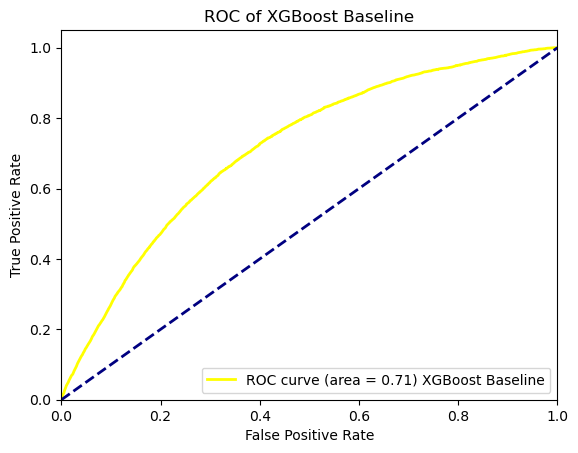

In [18]:
#from sklearn.metrics import roc_curve, auc

#y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]
a, b, _ = roc_curve(y_valid, y_valid_pred)
roc_auc_d = auc(a, b)
plt.figure()
plt.plot(
    a,
    b,
    color="yellow",
    lw=2,
    label="ROC curve (area = %0.2f) XGBoost Baseline" % roc_auc_d,
)
xy=[0, 1]
plt.plot(xy, xy, color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of XGBoost Baseline")
plt.legend(loc="lower right")

plt.savefig('../figures/XGBoost_baseline_1.png')
comet_exp_obj.log_figure(figure_name="XGBoost_baseline_1", 
                             figure=plt, overwrite=False, step=None)
plt.show()

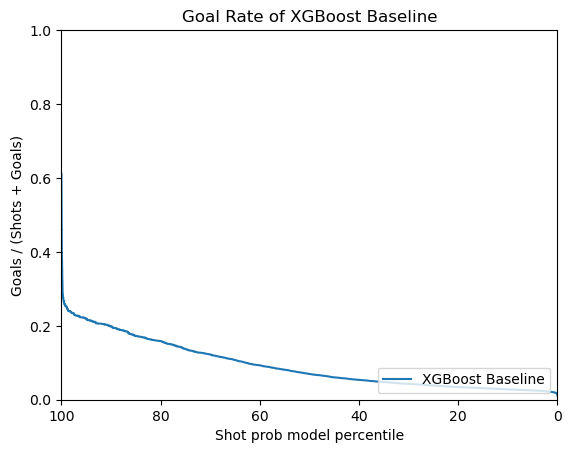

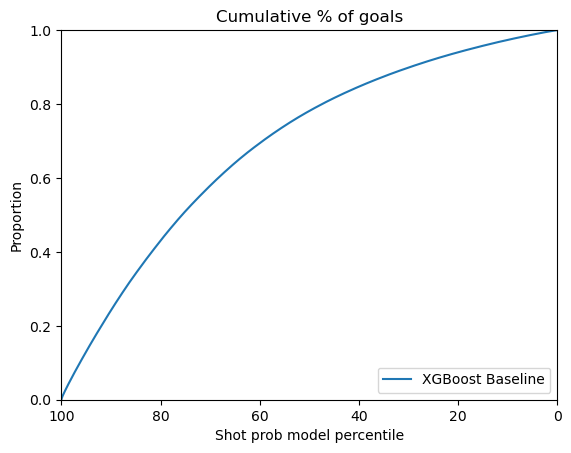

In [19]:
#model percentile
iu =y_valid_pred
n = len(iu)
x_axis = np.arange(n)[::-1]*(100/n)
#print(x_axis)

iu_y = iu[::-1]
iu_y[::-1].sort()
# print(sum(lr_probs_y))
#print(lr_probs_y)
iu_y_sum = np.cumsum(iu_y)


plt.figure()
plt.plot(
    x_axis,
    iu_y,
    label = 'XGBoost Baseline'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Goals / (Shots + Goals)")
plt.title("Goal Rate of XGBoost Baseline")
plt.legend(loc="lower right")
plt.savefig('../figures/XGBoost_baseline_2.png')
comet_exp_obj.log_figure(figure_name="XGBoost_baseline_2", 
                             figure=plt, overwrite=False, step=None)
plt.show()

#cumulative plot
plt.figure()
plt.plot(
    x_axis,
    iu_y_sum/sum(iu_y),
    label = 'XGBoost Baseline'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Proportion")
plt.title("Cumulative % of goals")
plt.legend(loc="lower right")
plt.savefig('../figures/XGBoost_baseline_3.png')
comet_exp_obj.log_figure(figure_name="XGBoost_baseline_3", 
                             figure=plt, overwrite=False, step=None)
plt.show()

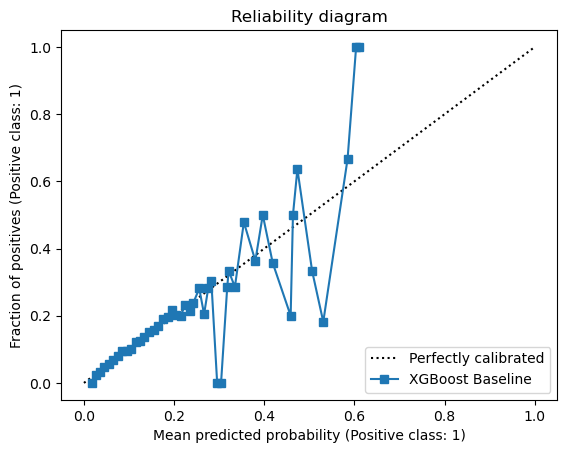

In [20]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_estimator(model_xgboost, X_valid, y_valid, name='XGBoost Baseline ', n_bins = 100)
plt.title("Reliability diagram")
plt.savefig('../figures/XGBoost_baseline_4.png')
comet_exp_obj.log_figure(figure_name="XGBoost_baseline_4", 
                             figure=plt, overwrite=False, step=None)
plt.show()

# Question 2: Training the XGBoost model with all the features obtained in feature engineering 2 and tuning the model.



In [18]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import math
import seaborn as sns

pd.set_option('display.max_columns', None)
from ift6758.data.Feature_Engineering2 import tidyData, getPreviousEvent
from ift6758.data.Feature_Engineering1 import combineAllFeatures
years = (2015,2016, 2017,2018)
for i in years : 
    tidyData(i)
df_2015_2016 = pd.read_csv('./2015Milestone2Dataset.csv')
df_2016_2017 = pd.read_csv('./2016Milestone2Dataset.csv')
df_2017_2018 = pd.read_csv('./2017Milestone2Dataset.csv')
df_2018_2019 = pd.read_csv('./2018Milestone2Dataset.csv')


file already exsiste
file already exsiste
file already exsiste
file already exsiste


In [19]:
training_df =  pd.concat([df_2015_2016, df_2016_2017,df_2017_2018,df_2018_2019])
train_set = combineAllFeatures(training_df)


In [20]:
df = getPreviousEvent(train_set)


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/khadidjabourega/Documents/Fall_2022/Data_Science/Projects/Project2/IFT6758_project1-milestone-2/ift6758/data/Feature_Engineering2.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_from_last_event'] = df['periodSeconds'] - df['last_periodSeconds']
/Users/khadidjabourega/Documents/Fall_2022/Data_Science/Projects/Project2/IFT6758_project1-milestone-2/ift6758/data/Feature_Engineering2.py:130: SettingWithCopyWarni

In [9]:
df

gameID eventType  period periodTime periodType  \
7       2015020001      Shot       1      00:51    REGULAR   
9       2015020001      Shot       1      01:05    REGULAR   
10      2015020001      Shot       1      01:06    REGULAR   
13      2015020001      Shot       1      01:53    REGULAR   
21      2015020001      Shot       1      02:37    REGULAR   
...            ...       ...     ...        ...        ...   
440604  2018030417      Goal       3      15:22    REGULAR   
440607  2018030417      Shot       3      15:51    REGULAR   
440608  2018030417      Shot       3      15:55    REGULAR   
440612  2018030417      Shot       3      16:50    REGULAR   
440617  2018030417      Goal       3      17:50    REGULAR   

              teamOfShooter homeOrAway  xCoord  yCoord           shooter  \
7       Toronto Maple Leafs       home   -55.0     6.0        Brad Boyes   
9       Toronto Maple Leafs       home   -79.0     0.0       Nazem Kadri   
10      Toronto Maple Leafs       home   -75.0    -1.0       Nazem Kadri   
13      Toronto Maple Leafs       home   -55.0   -36.0     Daniel Winnik   
21      Toronto Maple Leafs       home   -61.0    -1.0     Joffrey Lupul   
...                     ...        ...     ...     ...               ...   
440604      St. Louis Blues       away   -77.0     7.0      Zach Sanford   
440607      St. Louis Blues       away   -69.0     7.0   Alexander Steen   
440608      St. Louis Blues       away   -65.0    -4.0     Ryan O'Reilly   
440612        Boston Bruins       home    42.0     3.0  Marcus Johansson   
440617        Boston Bruins       home    44.0    24.0     Matt Grzelcyk   

                   goalie    shotType emptyNet strength  season rinkSide  \
7             Carey Price  Wrist Shot      NaN      NaN    2015    right   
9             Carey Price   Snap Shot      NaN      NaN    2015    right   
10            Carey Price   Snap Shot      NaN      NaN    2015    right   
13            Carey Price  Wrist Shot      NaN      NaN    2015    right   
21            Carey Price      Tip-In      NaN      NaN    2015    right   
...                   ...         ...      ...      ...     ...      ...   
440604        Tuukka Rask   Snap Shot    False     Even    2018    right   
440607        Tuukka Rask   Snap Shot      NaN      NaN    2018    right   
440608        Tuukka Rask   Snap Shot      NaN      NaN    2018    right   
440612  Jordan Binnington  Wrist Shot      NaN      NaN    2018     left   
440617  Jordan Binnington  Wrist Shot    False     Even    2018     left   

        Is_goal  empty_Net  Y_net  X_net  Distance_from_net  Angle_from_net  \
7             0          0      0    -89          34.525353       10.007980   
9             0          0      0    -89          10.000000        0.000000   
10            0          0      0    -89          14.035669        4.085617   
13            0          0      0    -89          49.517674       46.636577   
21            0          0      0    -89          28.017851        2.045408   
...         ...        ...    ...    ...                ...             ...   
440604        1          0      0    -89          13.892444       30.256437   
440607        0          0      0    -89          21.189620       19.290046   
440608        0          0      0    -89          24.331050        9.462322   
440612        0          0      0     89          47.095647        3.652223   
440617        1          0      0     89          51.000000       28.072487   

        periodSeconds last_EventType  last_period last_periodTime  \
7                51.0            Hit          1.0           00:40   
9                65.0       Giveaway          1.0           00:58   
10               66.0           Shot          1.0           01:05   
13              113.0            Hit          1.0           01:35   
21              157.0        Faceoff          1.0           02:32   
...               ...            ...          ...             ...   
440604   

In [21]:
comet_exp_obj.log_dataframe_profile(df, "dataframe after feature engineering 2")

COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET ERROR: dataframe conversion to 'json' failed; ignored


{'profile': None, 'dataframe': None}

In [22]:
print(df.shape)



(310931, 37)


In [24]:

df["rebound"].fillna(value=0)

df['rebound'].astype(int)

FinalDf = df[['Is_goal','period','periodSeconds',
              'last_EventType',
              'last_period',
             # 'last_periodTime',(not needed dince we have lastperiodseconds)
              'last_eventxCoord','last_eventyCoord',
             'last_shotType',
              'last_periodSeconds','last_Distance_from_net',
              'last_Angle_from_net',
              'time_from_last_event',
              'distance_from_last_event','rebound','change_in_angle','speed']]
obj_df=FinalDf.select_dtypes(include=['object']).copy()



FinalDf=FinalDf.drop(obj_df.columns, axis=1)

obj_df=obj_df.apply(preprocessing.LabelEncoder().fit_transform)

#Frame is the dataset used fpr xgboost later
Frame=pd.concat([FinalDf,obj_df],axis=1)
print(FinalDf)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(FinalDf)
Transformed_Values=imp_mean.transform(FinalDf)
TransformedDf = pd.DataFrame(Transformed_Values, index=FinalDf.index, columns=FinalDf.columns)
TransformedDf_=TransformedDf.drop("period",axis=1)
X = TransformedDf_.drop('Is_goal',axis=1)
y = TransformedDf_['Is_goal'].to_numpy()


        Is_goal  period  periodSeconds  last_period  last_eventxCoord  \
7             0       1           51.0          1.0              94.0   
9             0       1           65.0          1.0             -37.0   
10            0       1           66.0          1.0             -79.0   
13            0       1          113.0          1.0             -91.0   
21            0       1          157.0          1.0             -69.0   
...         ...     ...            ...          ...               ...   
412225        0       3          915.0          3.0             -60.0   
412228        0       3          923.0          3.0             -69.0   
412238        1       3         1145.0          3.0              17.0   
412240        0       3         1158.0          3.0               0.0   
412243        0       3         1165.0          3.0             -69.0   

        last_eventyCoord  last_periodSeconds  last_Distance_from_net  \
7                  -34.0                40.0       

In [12]:

X

periodSeconds  last_period  last_eventxCoord  last_eventyCoord  \
7                51.0          1.0              94.0             -34.0   
9                65.0          1.0             -37.0             -28.0   
10               66.0          1.0             -79.0               0.0   
13              113.0          1.0             -91.0              35.0   
21              157.0          1.0             -69.0             -22.0   
...               ...          ...               ...               ...   
440602          885.0          3.0              73.0              37.0   
440604          922.0          3.0             -57.0              34.0   
440607          951.0          3.0             -68.0             -29.0   
440608          955.0          3.0             -69.0               7.0   
440617         1070.0          3.0              45.0              -6.0   

        last_periodSeconds  last_Distance_from_net  last_Angle_from_net  \
7                     40.0               34.365681           171.634114   
9                     58.0               59.059292            28.300756   
10                    65.0               10.000000             0.000000   
13                    95.0               35.057096            86.729512   
21                   152.0               29.732137            47.726311   
...                    ...                     ...                  ...   
440602               878.0               40.311289            66.614779   
440604               891.0               46.690470            46.735705   
440607               939.0               35.805028            54.090277   
440608               951.0               21.189620            19.290046   
440617              1066.0               44.407207             7.765166   

        time_from_last_event  distance_from_last_event  rebound  \
7                       11.0                154.275727      0.0   
9                        7.0                 50.477718      0.0   
10                       1.0                  4.123106      1.0   
13                      18.0                 79.605276      0.0   
21                       5.0                 22.472205      0.0   
...                      ...                       ...      ...   
440602                   7.0                120.353646      0.0   
440604                  31.0                 33.600595      0.0   
440607                  12.0                 36.013886      0.0   
440608                   4.0                 11.704700      1.0   
440617                   4.0                 30.016662      0.0   

        change_in_angle      speed  
7              0.000000  14.025066  
9              0.000000   7.211103  
10             4.085617   4.123106  
13             0.000000   4.422515  
21             0.000000   4.494441  
...                 ...        ...  
440602         0.000000  17.193378  
440604         0.000000   1.083890  
440607         0.000000   3.001157  
440608        28.752368   2.926175  
440617         0.000000   7.504166  

[320181 rows x 12 columns]

In [13]:
y

array([0., 0., 0., ..., 0., 0., 1.])

In [25]:
X_train,X_valid, y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_valid.shape, y_train.shape,y_valid.shape

((248744, 12), (62187, 12), (248744,), (62187,))

In [15]:
X_train

periodSeconds  last_period  last_eventxCoord  last_eventyCoord  \
129644          771.0          1.0              80.0              25.0   
373441         1182.0          2.0               0.0               0.0   
64560           315.0          3.0             -17.0              37.0   
317202          964.0          2.0              71.0               4.0   
181205          229.0          1.0             -20.0              22.0   
...               ...          ...               ...               ...   
240455          920.0          3.0             -82.0             -40.0   
116271          358.0          3.0             -96.0               1.0   
305615          545.0          2.0              93.0             -33.0   
386277          865.0          2.0              69.0              22.0   
252107          711.0          2.0             -31.0             -11.0   

        last_periodSeconds  last_Distance_from_net  last_Angle_from_net  \
129644               770.0               26.570661            70.201124   
373441              1165.0               89.000000             0.000000   
64560                312.0               80.950602            27.198128   
317202               952.0               18.439089            12.528808   
181205               223.0               72.422372            17.684392   
...                    ...                     ...                  ...   
240455               912.0               40.607881            80.073754   
116271               354.0                7.071068             8.130102   
305615               526.0               33.241540           173.088773   
386277               835.0               29.732137            47.726311   
252107               708.0               59.033889            10.738897   

        time_from_last_event  distance_from_last_event  rebound  \
129644                   1.0                 24.083189      1.0   
373441                  17.0                 77.466122      0.0   
64560                    3.0                 93.477270      0.0   
317202                  12.0                124.458829      0.0   
181205                   6.0                 12.806248      0.0   
...                      ...                       ...      ...   
240455                   8.0                 41.194660      0.0   
116271                   4.0                 31.622777      0.0   
305615                  19.0                 40.162171      0.0   
386277                  30.0                114.354711      0.0   
252107                   3.0                 16.552945      0.0   

        change_in_angle      speed  
129644       -65.006695  24.083189  
373441         0.000000   4.556831  
64560          0.000000  31.159090  
317202         0.000000  10.371569  
181205         0.000000   2.134375  
...                 ...        ...  
240455         0.000000   5.149332  
116271         0.000000   7.905694  
305615         0.000000   2.113798  
386277         0.000000   3.811824  
252107         0.000000   5.517648  

[256144 rows x 12 columns]

# Hyperparamter tuning

In [26]:
learning_rate_list=[0.02,0.05,0.1]
max_depth_list =[5,7,10]
n_estimators_list = [2000, 3000,5000]
params_dict={"learning_rate": learning_rate_list,
            "max_depth": max_depth_list,
            "n_estimators": n_estimators_list}
num_combinations =1
for v in params_dict.values(): num_combinations *=len(v)
print(num_combinations)
params_dict

27


{'learning_rate': [0.02, 0.05, 0.1],
 'max_depth': [5, 7, 10],
 'n_estimators': [2000, 3000, 5000]}

In [27]:
def my_roc_auc_score(model,X,y):return roc_auc_score(y,model.predict_proba(X)[:,1])



In [29]:
model_xgboost_hp = GridSearchCV(estimator=xgb.XGBClassifier(subsample=0.5,
                                                        colsample_bytree=0.25,
                                                        eval_metric='auc',
                                                        use_label_encoder=False),
                            param_grid=params_dict,
                            cv=4,
                            scoring= my_roc_auc_score,
                            return_train_score=True,
                            verbose=4)
model_xgboost_hp.fit(X,y)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.02, max_depth=5, n_estimators=2000;, score=(train=0.748, test=0.675) total time= 3.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.02, max_depth=5, n_estimators=2000;, score=(train=0.746, test=0.678) total time= 4.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.02, max_depth=5, n_estimators=2000;, score=(train=0.745, test=0.680) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.02, max_depth=5, n_estimators=2000;, score=(train=0.748, test=0.671) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.02, max_depth=5, n_estimators=3000;, score=(train=0.769, test=0.675) total time= 5.3min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.02, max_depth=5, n_estimators=3000;, score=(train=0.767, test=0.678) total time= 5.3min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.02, max_depth=5, n_estimators=3000;, score=(train=0.766, test=0.680) total time= 5.7min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.02, max_depth=5, n_estimators=3000;, score=(train=0.768, test=0.671) total time= 5.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.02, max_depth=5, n_estimators=5000;, score=(train=0.800, test=0.672) total time=17.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.02, max_depth=5, n_estimators=5000;, score=(train=0.799, test=0.674) total time= 8.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.02, max_depth=5, n_estimators=5000;, score=(train=0.798, test=0.676) total time= 8.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.02, max_depth=5, n_estimators=5000;, score=(train=0.800, test=0.668) total time= 8.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.02, max_depth=7, n_estimators=2000;, score=(train=0.820, test=0.673) total time= 4.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.02, max_depth=7, n_estimators=2000;, score=(train=0.819, test=0.676) total time= 4.7min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.02, max_depth=7, n_estimators=2000;, score=(train=0.818, test=0.677) total time= 4.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.02, max_depth=7, n_estimators=2000;, score=(train=0.818, test=0.670) total time= 4.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.02, max_depth=7, n_estimators=3000;, score=(train=0.852, test=0.670) total time= 6.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.02, max_depth=7, n_estimators=3000;, score=(train=0.851, test=0.673) total time= 7.0min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.02, max_depth=7, n_estimators=3000;, score=(train=0.850, test=0.674) total time= 6.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.02, max_depth=7, n_estimators=3000;, score=(train=0.850, test=0.667) total time= 7.0min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.02, max_depth=7, n_estimators=5000;, score=(train=0.894, test=0.662) total time=12.4min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.02, max_depth=7, n_estimators=5000;, score=(train=0.895, test=0.664) total time=14.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.02, max_depth=7, n_estimators=5000;, score=(train=0.894, test=0.665) total time=18.7min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.02, max_depth=7, n_estimators=5000;, score=(train=0.894, test=0.659) total time=19.3min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.02, max_depth=10, n_estimators=2000;, score=(train=0.931, test=0.662) total time= 9.7min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.02, max_depth=10, n_estimators=2000;, score=(train=0.932, test=0.666) total time=10.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.02, max_depth=10, n_estimators=2000;, score=(train=0.931, test=0.664) total time=10.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.02, max_depth=10, n_estimators=2000;, score=(train=0.930, test=0.659) total time= 9.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.02, max_depth=10, n_estimators=3000;, score=(train=0.959, test=0.654) total time=14.0min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.02, max_depth=10, n_estimators=3000;, score=(train=0.960, test=0.657) total time=15.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.02, max_depth=10, n_estimators=3000;, score=(train=0.959, test=0.656) total time=14.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.02, max_depth=10, n_estimators=3000;, score=(train=0.958, test=0.651) total time= 9.4min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.02, max_depth=10, n_estimators=5000;, score=(train=0.984, test=0.640) total time=15.5min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.02, max_depth=10, n_estimators=5000;, score=(train=0.985, test=0.641) total time=16.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.02, max_depth=10, n_estimators=5000;, score=(train=0.985, test=0.641) total time=16.2min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.02, max_depth=10, n_estimators=5000;, score=(train=0.984, test=0.638) total time=16.2min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.05, max_depth=5, n_estimators=2000;, score=(train=0.796, test=0.669) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.05, max_depth=5, n_estimators=2000;, score=(train=0.795, test=0.673) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.05, max_depth=5, n_estimators=2000;, score=(train=0.793, test=0.675) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.05, max_depth=5, n_estimators=2000;, score=(train=0.795, test=0.667) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.05, max_depth=5, n_estimators=3000;, score=(train=0.825, test=0.664) total time= 8.3min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.05, max_depth=5, n_estimators=3000;, score=(train=0.824, test=0.668) total time= 9.0min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.05, max_depth=5, n_estimators=3000;, score=(train=0.823, test=0.670) total time= 8.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.05, max_depth=5, n_estimators=3000;, score=(train=0.824, test=0.663) total time= 8.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.05, max_depth=5, n_estimators=5000;, score=(train=0.865, test=0.657) total time=14.2min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.05, max_depth=5, n_estimators=5000;, score=(train=0.865, test=0.660) total time=13.2min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.05, max_depth=5, n_estimators=5000;, score=(train=0.864, test=0.660) total time=11.4min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.05, max_depth=5, n_estimators=5000;, score=(train=0.865, test=0.655) total time= 9.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.05, max_depth=7, n_estimators=2000;, score=(train=0.889, test=0.656) total time= 4.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.05, max_depth=7, n_estimators=2000;, score=(train=0.890, test=0.662) total time= 4.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.05, max_depth=7, n_estimators=2000;, score=(train=0.887, test=0.663) total time= 4.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.05, max_depth=7, n_estimators=2000;, score=(train=0.888, test=0.655) total time= 4.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.05, max_depth=7, n_estimators=3000;, score=(train=0.925, test=0.647) total time= 6.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.05, max_depth=7, n_estimators=3000;, score=(train=0.925, test=0.653) total time= 6.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.05, max_depth=7, n_estimators=3000;, score=(train=0.923, test=0.655) total time=45.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.05, max_depth=7, n_estimators=3000;, score=(train=0.924, test=0.647) total time= 7.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.05, max_depth=7, n_estimators=5000;, score=(train=0.963, test=0.634) total time=11.5min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.05, max_depth=7, n_estimators=5000;, score=(train=0.963, test=0.637) total time=12.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.05, max_depth=7, n_estimators=5000;, score=(train=0.962, test=0.640) total time=11.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.05, max_depth=7, n_estimators=5000;, score=(train=0.963, test=0.634) total time=13.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.05, max_depth=10, n_estimators=2000;, score=(train=0.982, test=0.634) total time=10.2min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.05, max_depth=10, n_estimators=2000;, score=(train=0.983, test=0.637) total time=10.5min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.05, max_depth=10, n_estimators=2000;, score=(train=0.982, test=0.639) total time=32.4min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.05, max_depth=10, n_estimators=2000;, score=(train=0.982, test=0.635) total time= 9.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.05, max_depth=10, n_estimators=3000;, score=(train=0.994, test=0.622) total time=15.7min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.05, max_depth=10, n_estimators=3000;, score=(train=0.994, test=0.625) total time=15.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.05, max_depth=10, n_estimators=3000;, score=(train=0.994, test=0.627) total time=15.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.05, max_depth=10, n_estimators=3000;, score=(train=0.994, test=0.624) total time=28.7min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.05, max_depth=10, n_estimators=5000;, score=(train=0.999, test=0.611) total time=26.5min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.05, max_depth=10, n_estimators=5000;, score=(train=0.999, test=0.612) total time=16.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.05, max_depth=10, n_estimators=5000;, score=(train=0.999, test=0.614) total time=15.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.05, max_depth=10, n_estimators=5000;, score=(train=0.999, test=0.611) total time=15.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.1, max_depth=5, n_estimators=2000;, score=(train=0.841, test=0.654) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.1, max_depth=5, n_estimators=2000;, score=(train=0.839, test=0.658) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.1, max_depth=5, n_estimators=2000;, score=(train=0.838, test=0.661) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.1, max_depth=5, n_estimators=2000;, score=(train=0.838, test=0.654) total time= 3.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.1, max_depth=5, n_estimators=3000;, score=(train=0.875, test=0.645) total time= 5.4min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.1, max_depth=5, n_estimators=3000;, score=(train=0.873, test=0.650) total time= 5.3min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.1, max_depth=5, n_estimators=3000;, score=(train=0.872, test=0.653) total time=40.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.1, max_depth=5, n_estimators=3000;, score=(train=0.872, test=0.646) total time= 5.4min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.1, max_depth=5, n_estimators=5000;, score=(train=0.917, test=0.632) total time= 8.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.1, max_depth=5, n_estimators=5000;, score=(train=0.916, test=0.637) total time= 8.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.1, max_depth=5, n_estimators=5000;, score=(train=0.915, test=0.640) total time=113.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.1, max_depth=5, n_estimators=5000;, score=(train=0.916, test=0.633) total time=14.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.1, max_depth=7, n_estimators=2000;, score=(train=0.940, test=0.634) total time= 7.7min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.1, max_depth=7, n_estimators=2000;, score=(train=0.940, test=0.638) total time=37.2min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.1, max_depth=7, n_estimators=2000;, score=(train=0.939, test=0.641) total time= 4.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.1, max_depth=7, n_estimators=2000;, score=(train=0.939, test=0.636) total time= 4.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.1, max_depth=7, n_estimators=3000;, score=(train=0.969, test=0.624) total time= 6.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.1, max_depth=7, n_estimators=3000;, score=(train=0.969, test=0.626) total time= 6.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.1, max_depth=7, n_estimators=3000;, score=(train=0.968, test=0.630) total time=48.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.1, max_depth=7, n_estimators=3000;, score=(train=0.969, test=0.626) total time=11.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.1, max_depth=7, n_estimators=5000;, score=(train=0.992, test=0.613) total time=41.1min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.1, max_depth=7, n_estimators=5000;, score=(train=0.992, test=0.612) total time=67.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.1, max_depth=7, n_estimators=5000;, score=(train=0.991, test=0.617) total time=19.4min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.1, max_depth=7, n_estimators=5000;, score=(train=0.991, test=0.611) total time=19.4min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.1, max_depth=10, n_estimators=2000;, score=(train=0.998, test=0.612) total time=10.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.1, max_depth=10, n_estimators=2000;, score=(train=0.997, test=0.612) total time=10.5min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.1, max_depth=10, n_estimators=2000;, score=(train=0.997, test=0.615) total time=10.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.1, max_depth=10, n_estimators=2000;, score=(train=0.997, test=0.609) total time=10.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.1, max_depth=10, n_estimators=3000;, score=(train=1.000, test=0.606) total time=15.8min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.1, max_depth=10, n_estimators=3000;, score=(train=1.000, test=0.605) total time=14.3min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.1, max_depth=10, n_estimators=3000;, score=(train=1.000, test=0.607) total time= 9.7min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.1, max_depth=10, n_estimators=3000;, score=(train=1.000, test=0.603) total time=10.5min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 1/4] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=(train=1.000, test=0.602) total time=21.6min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 2/4] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=(train=1.000, test=0.602) total time=53.9min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 3/4] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=(train=1.000, test=0.602) total time=16.5min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[CV 4/4] END learning_rate=0.1, max_depth=10, n_estimators=5000;, score=(train=1.000, test=0.598) total time=26.2min


C:\Users\HP\miniconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.25,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=0.5, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=None),
             param_grid={'learning_rate': [0.02, 0.05, 0.1],
                         'max_depth': [5, 7, 10],
                         'n_estimators': [2000, 3000, 5000]},
             return_train_score=True,
             scoring=<function my_roc_auc_score at 0x000001D6B399E310>,
             verbose=4)

In [37]:
filename = '../model/model_xgboost_hp.pkl'
pickle.dump(model_xgboost_hp, open(filename, 'wb'))
comet_exp_obj.log_model('model_xgboost_hp',file_or_folder=filename, overwrite=True, file_name='model_xgboost_hp')


NameError: name 'model_xgboost_hp' is not defined

In [30]:
df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate','param_max_depth','param_n_estimators']]
df_cv_results.sort_values(by='rank_test_score',inplace=True)
df_cv_results



NameError: name 'model_xgboost_hp' is not defined

In [ ]:
comet_exp_obj.log_dataframe_profile(df_cv_results, "dataframe for recording the grid serach results")

Text(0.5, 1.0, 'Performance wrt # of Trees and Depth')

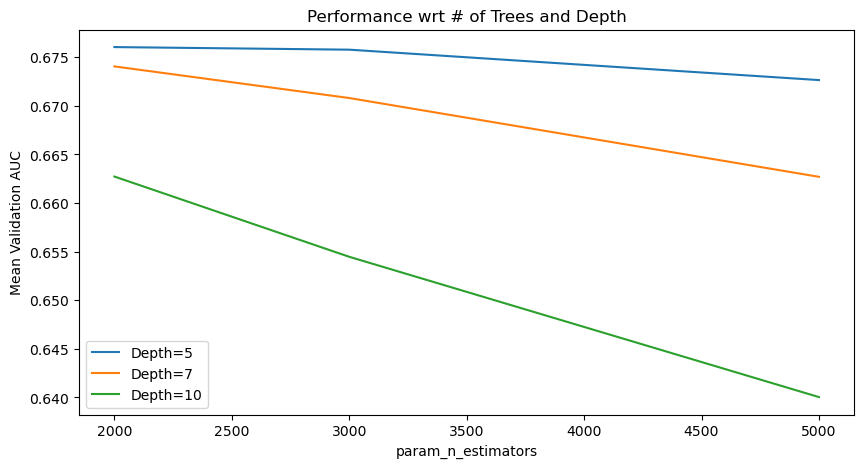

In [35]:
# First sort by number of estimators as that would be x-axis
df_cv_results.sort_values(by='param_n_estimators', inplace=True)

# Find values of AUC for learning rate of 0.02 and different values of depth
lr_d5 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.02) & (df_cv_results['param_max_depth']==5),:]
lr_d7 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.02) & (df_cv_results['param_max_depth']==7),:]
lr_d10 = df_cv_results.loc[(df_cv_results['param_learning_rate']==0.02) & (df_cv_results['param_max_depth']==10),:]


# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))
lr_d5.plot(x='param_n_estimators', y='mean_test_score', label='Depth=5', ax=ax)
lr_d7.plot(x='param_n_estimators', y='mean_test_score', label='Depth=7', ax=ax)
lr_d10.plot(x='param_n_estimators', y='mean_test_score', label='Depth=10', ax=ax)

plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt # of Trees and Depth')
comet_exp_obj.log_figure(figure_name="Performance wrt # of Trees and Depth", 
                             figure=plt, overwrite=False, step=None)

From the above figure, we can conclude that validation accuracy decreases as we increase the number of estimators and the depth of the tree for our data.

Text(0.5, 1.0, 'Performance wrt learning rate')

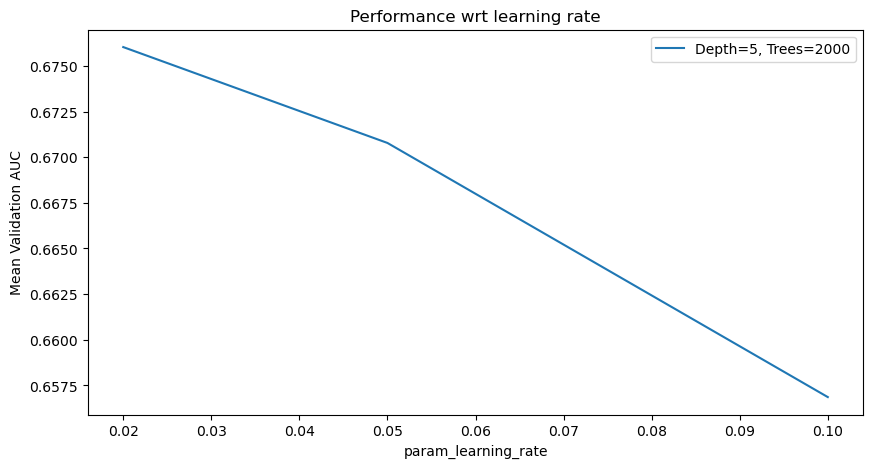

In [36]:
# First sort by learning rate as that would be x-axis
df_cv_results.sort_values(by='param_learning_rate', inplace=True)

# Find values of AUC for learning rate of 0.05 and different values of depth
lr_t3k_d2 = df_cv_results.loc[(df_cv_results['param_n_estimators']==2000) & (df_cv_results['param_max_depth']==5),:]

# Let us plot now
fig, ax = plt.subplots(figsize=(10,5))

lr_t3k_d2.plot(x='param_learning_rate', y='mean_test_score', label='Depth=5, Trees=2000', ax=ax)
plt.ylabel('Mean Validation AUC')
plt.title('Performance wrt learning rate')
comet_exp_obj.log_figure(figure_name="Performance wrt learning rate", 
                             figure=plt, overwrite=False, step=None)

# Final Model 

In [38]:
model_xgboost_fin = xgb.XGBClassifier(learning_rate=0.02,
                                          max_depth=5,
                                          n_estimators=2000,
                                          subsample=0.5,
                                          colsample_bytree=0.25,
                                          eval_metric='auc',
                                          verbosity=1,
                                          use_label_encoder=False)

X_train,X_valid, y_train,y_valid = train_test_split(X,y,test_size=0.2)
X_train.shape,X_valid.shape, y_train.shape,y_valid.shape
# Passing both training and validation dataset as we want to plot AUC for both
eval_set = [(X_train, y_train),(X_valid, y_valid)]

model_xgboost_fin.fit(X_train,
                  y_train,
                  early_stopping_rounds=20,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.57004	validation_1-auc:0.56933
[1]	validation_0-auc:0.60853	validation_1-auc:0.60819
[2]	validation_0-auc:0.61972	validation_1-auc:0.61879
[3]	validation_0-auc:0.61890	validation_1-auc:0.61740
[4]	validation_0-auc:0.62647	validation_1-auc:0.62248
[5]	validation_0-auc:0.63211	validation_1-auc:0.62757
[6]	validation_0-auc:0.62926	validation_1-auc:0.62539
[7]	validation_0-auc:0.62737	validation_1-auc:0.62328
[8]	validation_0-auc:0.63254	validation_1-auc:0.62831
[9]	validation_0-auc:0.63298	validation_1-auc:0.62897
[10]	validation_0-auc:0.64293	validation_1-auc:0.63735
[11]	validation_0-auc:0.64108	validation_1-auc:0.63594
[12]	validation_0-auc:0.63948	validation_1-auc:0.63464
[13]	validation_0-auc:0.63771	validation_1-auc:0.63310
[14]	validation_0-auc:0.63865	validation_1-auc:0.63390
[15]	validation_0-auc:0.63920	validation_1-auc:0.63442
[16]	validation_0-auc:0.63815	validation_1-auc:0.63351
[17]	validation_0-auc:0.63965	validation_1-auc:0.63479
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.25,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=1)

In [41]:
filename = '../model/model_xgboost_fin.pkl'
pickle.dump(model_xgboost_fin, open(filename, 'wb'))
comet_exp_obj.log_model('model_xgboost_hp',file_or_folder=filename, overwrite=True, file_name='model_xgboost_fin')


FileNotFoundError: [Errno 2] No such file or directory: '../model/model_xgboost_fin.pkl'

In [ ]:
model_xgboost_final2 = xgb.XGBClassifier(learning_rate=0.02,
                                          max_depth=6,
                                          n_estimators=2000,
                                          subsample=1,
                                          colsample_bytree=1,
                                          eval_metric='auc',
                                          verbosity=1,
                                          use_label_encoder=False)

#Passing both training and validation dataset as we want to plot AUC for both
eval_set = [(X_train, y_train),(X_valid, y_valid)]

model_xgboost_final2.fit(X_train,
                  y_train,
                  early_stopping_rounds=20,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.65669	validation_1-auc:0.64843
[1]	validation_0-auc:0.65717	validation_1-auc:0.64895
[2]	validation_0-auc:0.66352	validation_1-auc:0.65626
[3]	validation_0-auc:0.66337	validation_1-auc:0.65543
[4]	validation_0-auc:0.66503	validation_1-auc:0.65689
[5]	validation_0-auc:0.66536	validation_1-auc:0.65720
[6]	validation_0-auc:0.66581	validation_1-auc:0.65743
[7]	validation_0-auc:0.66636	validation_1-auc:0.65796
[8]	validation_0-auc:0.66701	validation_1-auc:0.65868
[9]	validation_0-auc:0.66790	validation_1-auc:0.65908
[10]	validation_0-auc:0.66800	validation_1-auc:0.65928
[11]	validation_0-auc:0.66852	validation_1-auc:0.65925
[12]	validation_0-auc:0.66894	validation_1-auc:0.65950
[13]	validation_0-auc:0.66932	validation_1-auc:0.66005
[14]	validation_0-auc:0.66971	validation_1-auc:0.66040
[15]	validation_0-auc:0.67000	validation_1-auc:0.66039
[16]	validation_0-auc:0.67015	validation_1-auc:0.66056
[17]	validation_0-auc:0.67098	validation_1-auc:0.66119
[18]	validation_0-au

In [45]:
filename = './model/' + "model_xgboost_final2.pkl"
pickle.dump(model_xgboost_final2, open(filename, 'wb'))
comet_exp_obj.log_model('model_xgboost_final2',file_or_folder=filename, overwrite=True, file_name='model_xgboost_final2')

{'web': 'https://www.comet.com/api/asset/download?assetId=3e4fdf5dc30f4c14a901005f94bd01f6&experimentKey=9f3f9c2c217148308905b85e2fa85ddd',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=3e4fdf5dc30f4c14a901005f94bd01f6&experimentKey=9f3f9c2c217148308905b85e2fa85ddd',
 'assetId': '3e4fdf5dc30f4c14a901005f94bd01f6'}

In [18]:
y_train_pred = model_xgboost_final2.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost_final2.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.7268
AUC Valid: 0.6767


# METRICS AND FIGURES FOR TUNED MODEL WITH FEATURES FOM FEATURE ENGINEERING2

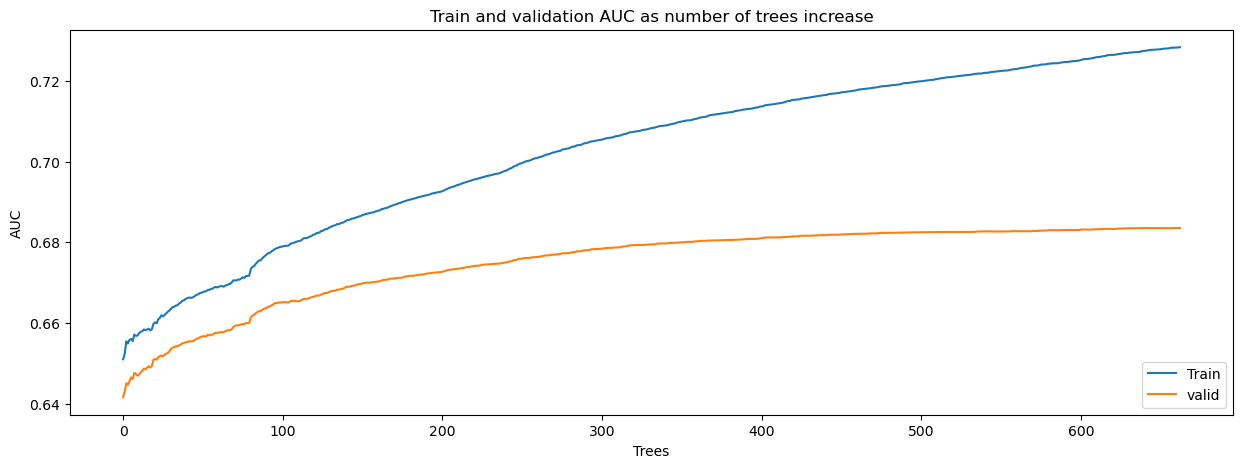

In [47]:
evaluation_results = model_xgboost_final2.evals_result()

# Index into each key to find AUC values for training and validation data after each tree
train_auc_tree = evaluation_results['validation_0']['auc']
valid_auc_tree = evaluation_results['validation_1']['auc']


# Plotting Section
plt.figure(figsize=(15,5))

plt.plot(train_auc_tree, label='Train')
plt.plot(valid_auc_tree, label='valid')

plt.title("Train and validation AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("AUC")
plt.legend(loc='lower right')
comet_exp_obj.log_figure(figure_name="Train and validation AUC as number of trees increase", 
                             figure=plt, overwrite=False, step=None)
plt.show()

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


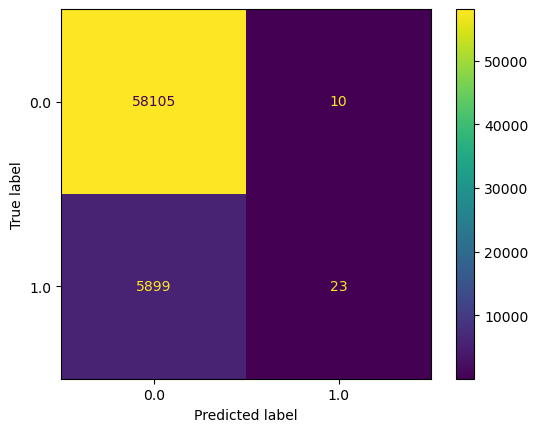

In [20]:
from sklearn.metrics import plot_confusion_matrix
y_test=y_valid
y_predicted= model_xgboost_final2.predict(X_valid)
plot_confusion_matrix(model_xgboost_final2,X_valid,y_valid)

In [49]:
comet_exp_obj.log_confusion_matrix(y_true=y_valid, y_predicted=y_predicted, title="Confusion Matrix for xgboost hp tuned model 2" ,
                                      file_name="Confusion Matrix for xgboost hp tuned model 2")

COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 1.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 1.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignoring it
COMET WARNING: Invalid y_true value 0.0, ignor

In [21]:
from sklearn.metrics import classification_report
metrics=classification_report(y_valid, y_predicted)

In [22]:
print(metrics)

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     58115
         1.0       0.70      0.00      0.01      5922

    accuracy                           0.91     64037
   macro avg       0.80      0.50      0.48     64037
weighted avg       0.89      0.91      0.86     64037



In [23]:
y_train_pred = model_xgboost_final2.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost_final2.predict_proba(X_valid)[:,1]
print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.7268
AUC Valid: 0.6767


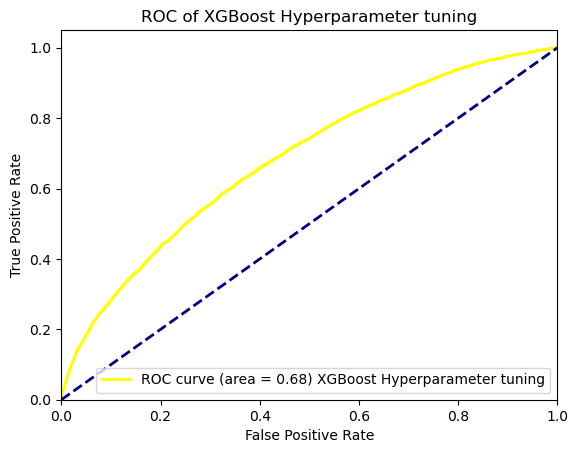

In [56]:
#y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]
a, b, _ = roc_curve(y_valid, y_valid_pred)
roc_auc_d = auc(a, b)
plt.figure()
plt.plot(
    a,
    b,
    color="yellow",
    lw=2,
    label="ROC curve (area = %0.2f) XGBoost Hyperparameter tuning" % roc_auc_d,
)
xy=[0, 1]
plt.plot(xy, xy, color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of XGBoost Hyperparameter tuning")
plt.legend(loc="lower right")

plt.savefig('../figures/XGBoost_hp_1.png')
comet_exp_obj.log_figure(figure_name="ROC of XGBoost Hyperparameter tuning", 
                             figure=plt, overwrite=False, step=None)
plt.show()

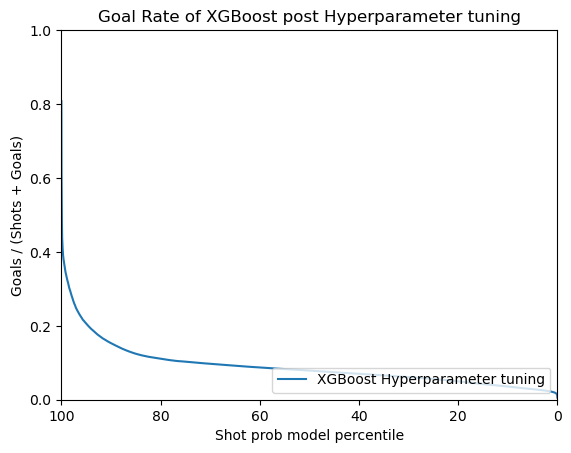

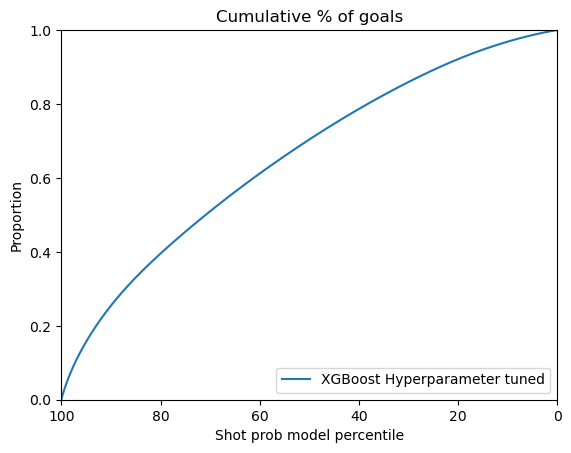

In [57]:
#model percentile
iu =y_valid_pred
n = len(iu)
x_axis = np.arange(n)[::-1]*(100/n)
#print(x_axis)

iu_y = iu[::-1]
iu_y[::-1].sort()
# print(sum(lr_probs_y))
#print(lr_probs_y)
iu_y_sum = np.cumsum(iu_y)


plt.figure()
plt.plot(
    x_axis,
    iu_y,
    label = 'XGBoost Hyperparameter tuning'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Goals / (Shots + Goals)")
plt.title("Goal Rate of XGBoost post Hyperparameter tuning")
plt.legend(loc="lower right")
plt.savefig('../figures/XGBoost_hp_2.png')
comet_exp_obj.log_figure(figure_name="Goal Rate of XGBoost post Hyperparameter tuning", 
                             figure=plt, overwrite=False, step=None)
plt.show()

#cumulative plot
plt.figure()
plt.plot(
    x_axis,
    iu_y_sum/sum(iu_y),
    label = 'XGBoost Hyperparameter tuned'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Proportion")
plt.title("Cumulative % of goals")
plt.legend(loc="lower right")
plt.savefig('../figures/XGBoost_hp_3.png')
comet_exp_obj.log_figure(figure_name="Cumulative % of goals of xgboost hp", 
                             figure=plt, overwrite=False, step=None)
plt.show()

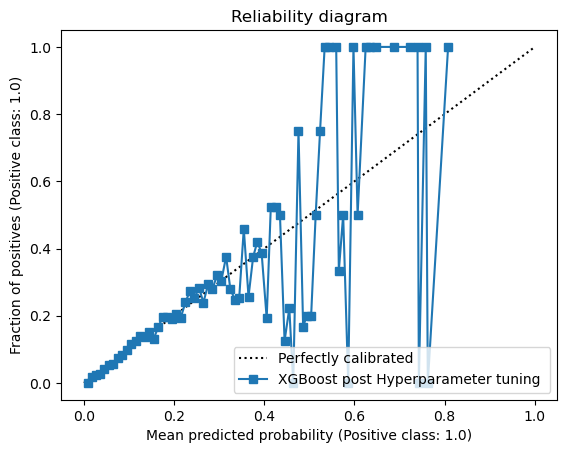

In [58]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_estimator(model_xgboost_final2, X_valid, y_valid, name='XGBoost post Hyperparameter tuning ', n_bins = 100)
plt.title("Reliability diagram")
plt.savefig('../figures/XGBoost_hp_4.png')
comet_exp_obj.log_figure(figure_name="Reliability diagram for xgboost post hyperparameter tuning", 
                             figure=plt, overwrite=False, step=None)
plt.show()

In [59]:
var_columns= list(X_train.columns)
df_var_imp = pd.DataFrame({"Variable": var_columns,
                           "Importance": model_xgboost_final2.feature_importances_}).sort_values(by='Importance', ascending=False)
df_var_imp[:10]


Variable  Importance
7       time_from_last_event    0.279791
1                last_period    0.138874
5     last_Distance_from_net    0.089182
10           change_in_angle    0.083168
8   distance_from_last_event    0.079926
6        last_Angle_from_net    0.068628
9                    rebound    0.055726
4         last_periodSeconds    0.052334
11                     speed    0.044877
0              periodSeconds    0.042189

In [60]:
comet_exp_obj.log_dataframe_profile(df_var_imp, "dataframe for recording the importance of features in order")

COMET WARNING: pandas_profiling is required to log profile; ignoring


{'profile': None,
 'dataframe': {'web': 'https://www.comet.com/api/asset/download?assetId=3a9ab4317d9d4b079f894d3cdb5c0c36&experimentKey=9f3f9c2c217148308905b85e2fa85ddd',
  'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=3a9ab4317d9d4b079f894d3cdb5c0c36&experimentKey=9f3f9c2c217148308905b85e2fa85ddd',
  'assetId': '3a9ab4317d9d4b079f894d3cdb5c0c36'}}

In [29]:
config = configparser.ConfigParser()
config.read('./configfile.ini')
type_env = "comet_ml_prod" #comet_ml_prod
COMET_API_KEY = config[type_env]['api_key']
COMET_PROJECT_NAME = config[type_env]['project_name_xgboost_shap']
COMET_WORKSPACE = config[type_env]['workspace']

comet_exp_obj = Experiment(api_key=COMET_API_KEY,
                           project_name=COMET_PROJECT_NAME,
                           workspace=COMET_WORKSPACE,
                           log_code=True
                          )
comet_exp_obj.set_name(name="XGBOOST MODELS SHAP")

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, xgboost, shap. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/yasmine/xgboost-shap/6863b758465e4dde8b7934f9943ebe1e



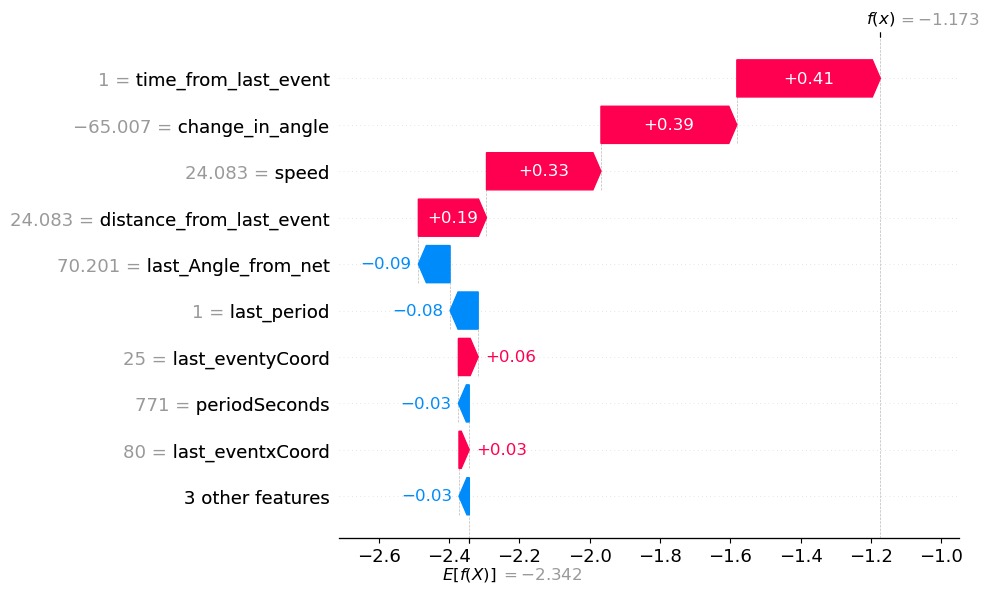

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


0.41.0


<Figure size 640x480 with 0 Axes>

In [30]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model_xgboost_final2)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
print(shap.__version__)
comet_exp_obj.log_figure(figure_name="feature importance using shap", 
                             figure=shap_visual, overwrite=False, step=None)

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue

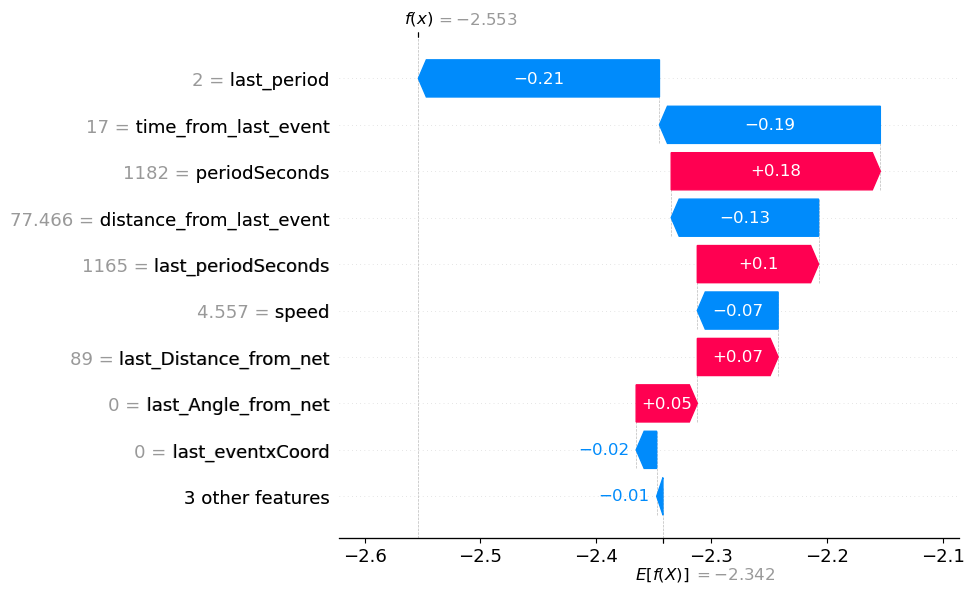

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [31]:
shap_visual=shap.plots.waterfall(shap_values[1])
comet_exp_obj.log_figure(figure_name="feature importance using shap1", 
                             figure=shap_visual, overwrite=False, step=None)

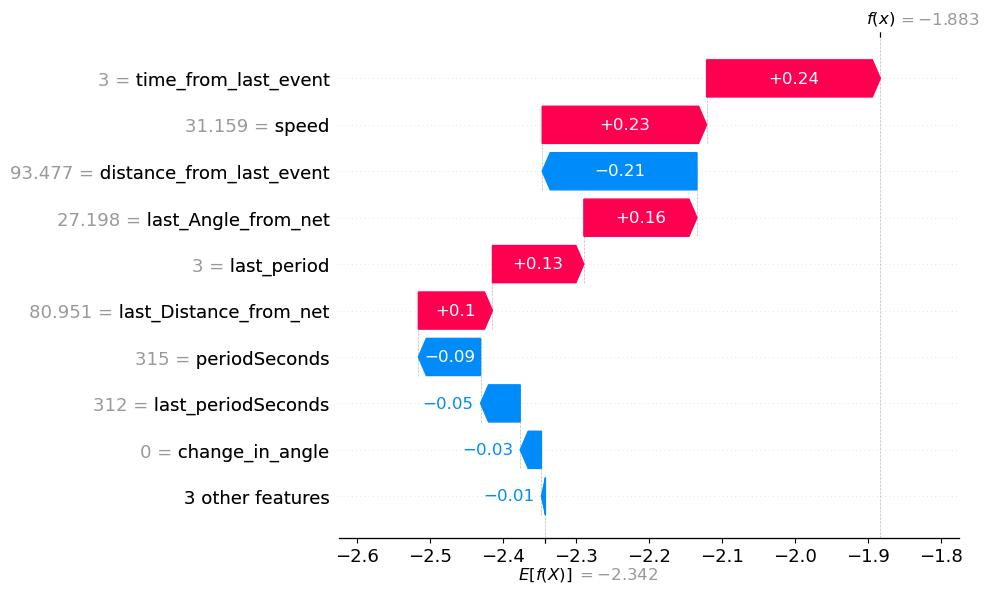

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [32]:
shap_visual=shap.plots.waterfall(shap_values[2])
comet_exp_obj.log_figure(figure_name="feature importance using shap2", 
                             figure=shap_visual, overwrite=False, step=None)

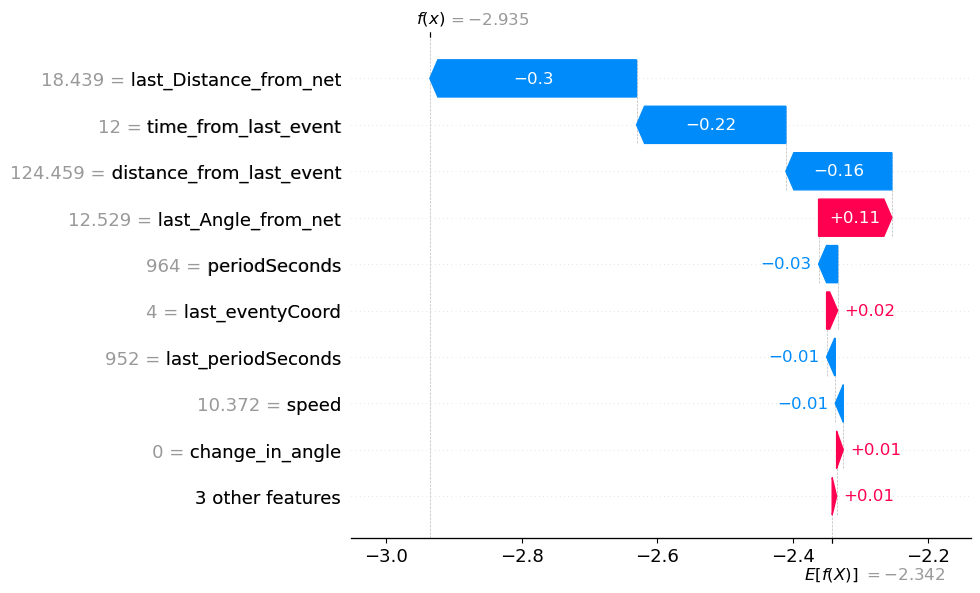

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [34]:
shap_visual=shap.plots.waterfall(shap_values[3])
comet_exp_obj.log_figure(figure_name="feature importance using shap3", 
                             figure=shap_visual, overwrite=False, step=None)

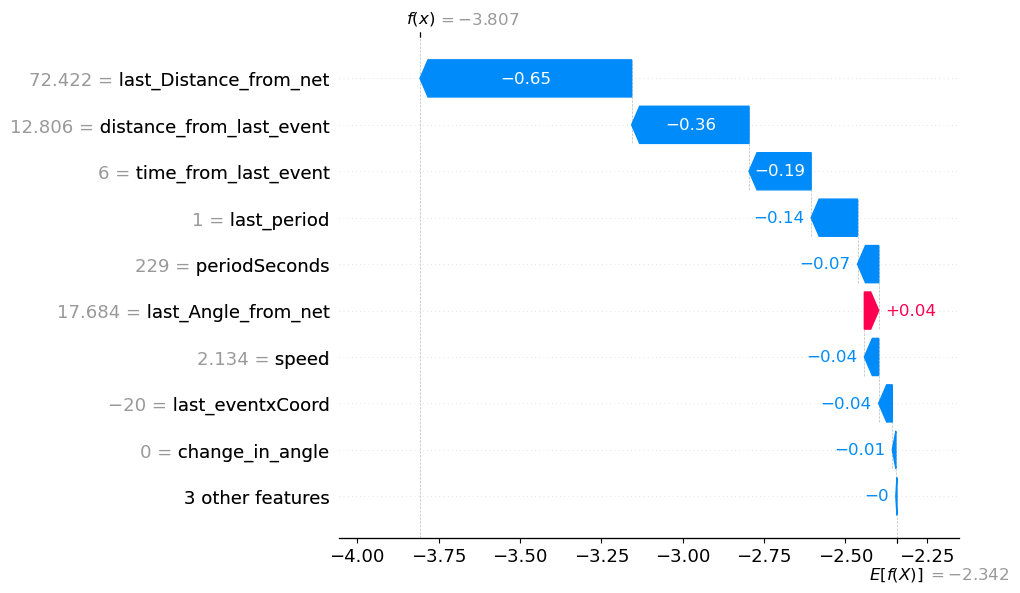

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


<Figure size 640x480 with 0 Axes>

In [35]:
shap_visual=shap.plots.waterfall(shap_values[4])
comet_exp_obj.log_figure(figure_name="feature importance using shap4", 
                             figure=shap_visual, overwrite=False, step=None)

COMET WARNING: Refuse to upload empty figure, please call log_figure before calling show
COMET WARNING: Failing to save the matplotlib figure


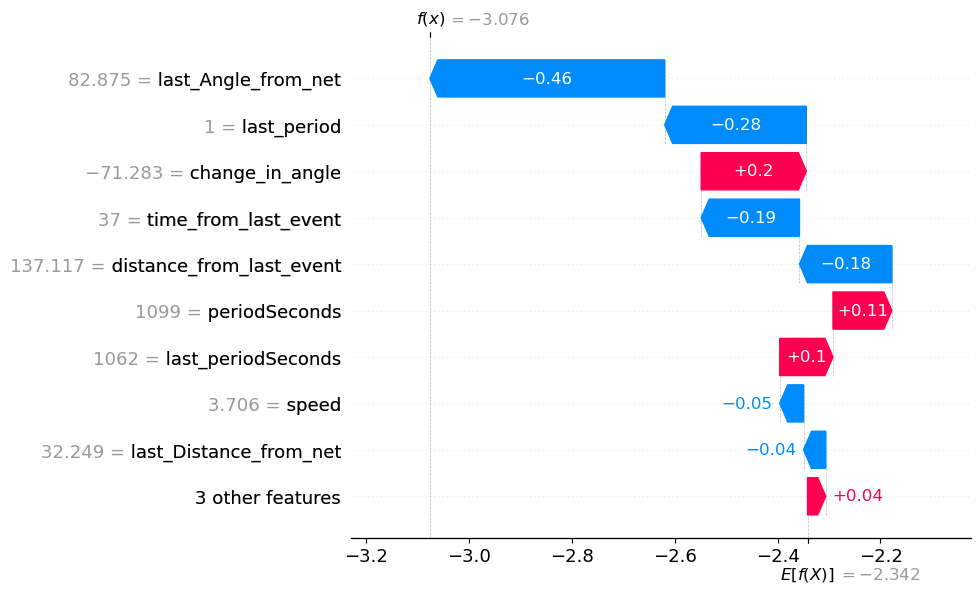

In [37]:
comet_exp_obj.log_figure(figure_name="feature importance using shap5", 
                             figure=shap_visual, overwrite=False, step=None)
shap_visual=shap.plots.waterfall(shap_values[5])


In [38]:
X_train_SHAP_features=X_train.loc[:,['time_from_last_event'
                                     ,'speed'
                                   ,'last_Angle_from_net','last_period','last_Distance_from_net']]

In [39]:
X_train_SHAP_features

time_from_last_event      speed  last_Angle_from_net  last_period  \
129644                   1.0  24.083189            70.201124          1.0   
373441                  17.0   4.556831             0.000000          2.0   
64560                    3.0  31.159090            27.198128          3.0   
317202                  12.0  10.371569            12.528808          2.0   
181205                   6.0   2.134375            17.684392          1.0   
...                      ...        ...                  ...          ...   
240455                   8.0   5.149332            80.073754          3.0   
116271                   4.0   7.905694             8.130102          3.0   
305615                  19.0   2.113798           173.088773          2.0   
386277                  30.0   3.811824            47.726311          2.0   
252107                   3.0   5.517648            10.738897          2.0   

        last_Distance_from_net  
129644               26.570661  
373441               89.000000  
64560                80.950602  
317202               18.439089  
181205               72.422372  
...                        ...  
240455               40.607881  
116271                7.071068  
305615               33.241540  
386277               29.732137  
252107               59.033889  

[256144 rows x 5 columns]

In [40]:
X_valid_SHAP_features=X_valid.loc[:,['time_from_last_event'
                                     ,'speed'
                                   ,'last_Angle_from_net','last_period','last_Distance_from_net']]
X_valid_SHAP_features

time_from_last_event      speed  last_Angle_from_net  last_period  \
332662                  23.0   6.404305            47.726311          3.0   
73418                   30.0   5.168387           163.300756          3.0   
166109                   3.0  10.749677            47.726311          2.0   
94101                    6.0   3.435921            47.726311          2.0   
43264                    9.0  13.037458            75.068583          3.0   
...                      ...        ...                  ...          ...   
86396                   67.0   0.716573             1.332220          1.0   
295700                  14.0   8.905685            23.198591          3.0   
176189                  33.0   3.713945            47.726311          1.0   
233688                   5.0   7.400000            82.874984          2.0   
395048                  80.0   0.091001            47.726311          3.0   

        last_Distance_from_net  
332662               29.732137  
73418                20.880613  
166109               29.732137  
94101                29.732137  
43264                31.048349  
...                        ...  
86396                86.023253  
295700               15.231546  
176189               29.732137  
233688                8.062258  
395048               29.732137  

[64037 rows x 5 columns]

In [41]:
model_xgboost_shap = xgb.XGBClassifier(learning_rate = 0.02, 
                                 max_depth=6,
                                 n_estimators = 2000,
                                 subsample=1,
                                 colsample_bytree =1,
                                 eval_metric='auc',
                                  verbosity=1 )
eval_set=[(X_valid_SHAP_features,y_valid)]

In [42]:
model_xgboost_shap.fit(X_train_SHAP_features,y_train,early_stopping_rounds=10,eval_set=eval_set,verbose=True)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-auc:0.60583
[1]	validation_0-auc:0.60694
[2]	validation_0-auc:0.60669
[3]	validation_0-auc:0.61066
[4]	validation_0-auc:0.61099
[5]	validation_0-auc:0.61143
[6]	validation_0-auc:0.61156
[7]	validation_0-auc:0.61160
[8]	validation_0-auc:0.61191
[9]	validation_0-auc:0.61198
[10]	validation_0-auc:0.61191
[11]	validation_0-auc:0.61178
[12]	validation_0-auc:0.61207
[13]	validation_0-auc:0.61260
[14]	validation_0-auc:0.61275
[15]	validation_0-auc:0.61275
[16]	validation_0-auc:0.61298
[17]	validation_0-auc:0.61286
[18]	validation_0-auc:0.61291
[19]	validation_0-auc:0.61296
[20]	validation_0-auc:0.61302
[21]	validation_0-auc:0.61339
[22]	validation_0-auc:0.61354
[23]	validation_0-auc:0.61359
[24]	validation_0-auc:0.61337
[25]	validation_0-auc:0.61367
[26]	validation_0-auc:0.61382
[27]	validation_0-auc:0.61393
[28]	validation_0-auc:0.61405
[29]	validation_0-auc:0.61404
[30]	validation_0-auc:0.61397
[31]	validation_0-auc:0.61417
[32]	validation_0-auc:0.61444
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2000, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [43]:
filename = './model/' + "model_xgboost_shap_0.pkl"
pickle.dump(model_xgboost_final2, open(filename, 'wb'))
comet_exp_obj.log_model('model_xgboost_shap_0',file_or_folder=filename, overwrite=True, file_name='model_xgboost_shap_0')

{'web': 'https://www.comet.com/api/asset/download?assetId=15a0bc92a8f44ed494f2e9df57aeb372&experimentKey=6863b758465e4dde8b7934f9943ebe1e',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=15a0bc92a8f44ed494f2e9df57aeb372&experimentKey=6863b758465e4dde8b7934f9943ebe1e',
 'assetId': '15a0bc92a8f44ed494f2e9df57aeb372'}

In [44]:
model_xgboost_shap_1 = xgb.XGBClassifier(learning_rate = 0.1, 
                                 max_depth=7,
                                 n_estimators = 5000,
                                 subsample=0.5,
                                 colsample_bytree =0.5,
                                 eval_metric='auc',
                                  verbosity=1 )
eval_set=[(X_valid_SHAP_features,y_valid)]

In [45]:
model_xgboost_shap_1.fit(X_train_SHAP_features,y_train,early_stopping_rounds=20,eval_set=eval_set,verbose=True)

[0]	validation_0-auc:0.59003
[1]	validation_0-auc:0.59515
[2]	validation_0-auc:0.59592
[3]	validation_0-auc:0.59440
[4]	validation_0-auc:0.59327
[5]	validation_0-auc:0.59371
[6]	validation_0-auc:0.59329
[7]	validation_0-auc:0.59210
[8]	validation_0-auc:0.59962
[9]	validation_0-auc:0.60079
[10]	validation_0-auc:0.60135
[11]	validation_0-auc:0.60255
[12]	validation_0-auc:0.60397
[13]	validation_0-auc:0.60355
[14]	validation_0-auc:0.60610
[15]	validation_0-auc:0.60650
[16]	validation_0-auc:0.60571
[17]	validation_0-auc:0.60537
[18]	validation_0-auc:0.60578
[19]	validation_0-auc:0.60581
[20]	validation_0-auc:0.60531
[21]	validation_0-auc:0.60561
[22]	validation_0-auc:0.60649
[23]	validation_0-auc:0.60615
[24]	validation_0-auc:0.60634
[25]	validation_0-auc:0.60654
[26]	validation_0-auc:0.60651
[27]	validation_0-auc:0.60636
[28]	validation_0-auc:0.60620
[29]	validation_0-auc:0.60525
[30]	validation_0-auc:0.60514
[31]	validation_0-auc:0.60502
[32]	validation_0-auc:0.60494
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=4, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.5, tree_method='exact',
              validate_parameters=1, verbosity=1)